In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
import h5py

from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation

from algo.agent import make_DiscreteDrQ_agent
from algo.wrapper import TensorObservation
from algo import utils

torch.Size([3, 84, 84]) <class 'torch.Tensor'>


A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]
/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/tagokeniot/tmp/wrapper.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.as_tensor(observation, dtype=torch.float32)


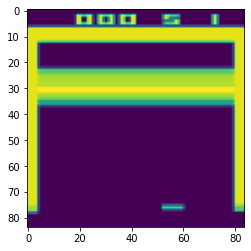

In [2]:
env = gym.make('Breakout-v4')
env = GrayScaleObservation(ResizeObservation(env, 84))
env = TensorObservation(FrameStack(env, 3))
obs = env.reset()
print(obs.shape, type(obs))
plt.imshow(obs[0])

In [3]:
env.action_space.sample()

0

In [4]:
################# Task Setting ####################
# reference ./conf/ 
TARGET = 'treasure_hunt_with_fixed_room'
EXPERIMENT_NAME = 'test_breakout'
###################################################

cfg = utils.load_param('conf', 'train_config.yaml', [f'task={TARGET}', f'experiment_name={EXPERIMENT_NAME}'])

workspace_path = utils.get_workspace_path(cfg.experiment_name)

In [5]:
import shutil

shutil.rmtree(str(workspace_path))

In [6]:
utils.create_workspace(cfg.experiment_name)

gpu = torch.cuda.current_device() if torch.cuda.is_available() else -1


print(f'obs_space: \t{env.observation_space.shape} \naction_space: \t{env.action_space.n}')
    
obs = env.reset()

agent = make_DiscreteDrQ_agent(
    experiment_name=cfg.experiment_name, 
    obs_space=env.observation_space, 
    action_space=env.action_space,
    feature_dim=cfg.feature_dim,
    hidden_dim=cfg.hidden_dim,
    lr=cfg.lr,
    image_pad=cfg.image_pad,
    gamma=cfg.gamma,
    replay_start_size=cfg.replay_start_size,
    capacity=cfg.capacity,
    gpu=gpu,
    batch_size=cfg.batch_size,
    update_interval=cfg.update_interval,
    is_persistent_buffer=True)

result_filename = f'{str(workspace_path)}/result.hdf5'

with h5py.File(result_filename, 'a') as f:
    agent_statics_group = 'agent_statics'
    agent_statics_labels = [s[0] for s in agent.get_statistics()]
    for l in agent_statics_labels:
        f.create_dataset(f'{agent_statics_group}/{l}', shape=(cfg.n_episodes,))

    episode_rewards_group = 'episode_rewards'
    episode_rewards_labels = ['episode', 'total_reward']
    for l in episode_rewards_labels:
        f.create_dataset(f'{episode_rewards_group}/{l}', shape=(cfg.n_episodes,))

import datetime
start = datetime.datetime.now()
print(f'\n====================\nStart Training: {start}\n====================\n')

for i in range(cfg.n_episodes):
    obs = env.reset()
    R = 0  # return (sum of rewards)
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        
        agent.observe(obs, reward, done, done)
        if done:
            break

    print('=============')
    print(f'episode: {i}, reward: {R}')
    print(f'statics: {agent.get_statistics()}')
    
    ## record result
    with h5py.File(result_filename, 'a') as f:
        f[episode_rewards_group]['episode'][i] = i+1
        f[episode_rewards_group]['total_reward'][i] = R
        for statics in agent.get_statistics():
            f[agent_statics_group][statics[0]][i] = statics[1]

print('Finished')
print(f'\n====================\nTraining Time: {datetime.datetime.now() - start}\n====================\n')

agent.save(f'{str(workspace_path)}/agent')



set workspace: work/test_breakout
obs_space: 	(3, 84, 84) 
action_space: 	4
set workspace: work/test_breakout

Start Training: 2022-01-10 19:03:11.760367

episode: 0, reward: 3.0
statics: [('average_q1', nan), ('average_q2', nan), ('average_q_func1_loss', nan), ('average_q_func2_loss', nan), ('n_updates', 0), ('average_entropy', nan), ('temperature', 1.0)]
episode: 1, reward: 2.0
statics: [('average_q1', nan), ('average_q2', nan), ('average_q_func1_loss', nan), ('average_q_func2_loss', nan), ('n_updates', 0), ('average_entropy', nan), ('temperature', 1.0)]
episode: 2, reward: 2.0
statics: [('average_q1', nan), ('average_q2', nan), ('average_q_func1_loss', nan), ('average_q_func2_loss', nan), ('n_updates', 0), ('average_entropy', nan), ('temperature', 1.0)]
episode: 3, reward: 1.0
statics: [('average_q1', nan), ('average_q2', nan), ('average_q_func1_loss', nan), ('average_q_func2_loss', nan), ('n_updates', 0), ('average_entropy', nan), ('temperature', 1.0)]
episode: 4, reward: 0.0
stati

ValueError: Expected parameter probs (Tensor of shape (1, 4)) of distribution Categorical(probs: torch.Size([1, 4])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan, nan, nan]], device='cuda:0')

In [ ]:
from torch import distributions as dists
probs = torch.softmax(torch.tensor([[1,2,3],[2,3,5]]).float(), dim=1)
ca = dists.Categorical(probs)
ca.probs.argmax(dim=-1)